In [1]:
pip install ray


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 MB 13.4 MB/s eta 0:00:00


In [2]:
import time
import pandas as pd
import ray
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Start Ray
ray.init()

2023-12-02 20:40:46,560	INFO worker.py:1673 -- Started a local Ray instance.


Python version:,3.10.12
Ray version:,2.8.1


In [27]:
from google.colab import files

# Upload the CSV file
uploaded = files.upload()

Saving 6kdata.csv to 6kdata.csv


In [28]:
# Load your CSV file into a Pandas DataFrame
start_time = time.time()
df = pd.read_csv('6kdata.csv')

In [29]:
# Assuming 'df' is your PySpark DataFrame
num_data_points = df.count()

print(f"Number of data points: {num_data_points}")

Number of data points: Time              5999
Review            5968
Time of Visit     4463
Tokens            5999
Stemmed Tokens    5999
POS Tags          2013
Sentiment         5999
dtype: int64


In [31]:
# Filter the 'Sentiment' column values to only include 'Neutral', 'Negative', 'Positive'
allowed_sentiments = ['Neutral', 'Negative', 'Positive']
df = df[df['Sentiment'].isin(allowed_sentiments)]

# Select only the 'Review' and 'Sentiment' columns
df = df[['Review', 'Sentiment']]

In [32]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['Review'], df['Sentiment'], test_size=0.2, random_state=42)

In [34]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
data_loading_preprocessing_time = time.time() - start_time

In [35]:
# Define a function to train the model
@ray.remote
def train_model(X_train, y_train, X_test, y_test):
    start_time = time.time()
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    start_time = time.time()
    predictions = model.predict(X_test)
    prediction_time = time.time() - start_time

    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')
    conf_matrix = confusion_matrix(y_test, predictions)

    return model, accuracy, precision, recall, f1, conf_matrix, training_time, prediction_time

In [36]:
# Train the model in parallel
start_time = time.time()
model_id = train_model.remote(X_train_tfidf, y_train, X_test_tfidf, y_test)
model, accuracy, precision, recall, f1, conf_matrix, training_time, prediction_time = ray.get(model_id)
total_time = time.time() - start_time

2023-12-02 21:10:05,892	INFO worker.py:1673 -- Started a local Ray instance.


In [38]:
# Print results
print(f"Total Time: {total_time:.2f} seconds")
print(f"Data Loading and Preprocessing Time: {data_loading_preprocessing_time:.2f} seconds")
print(f"Training Time: {training_time:.2f} seconds")
print(f"Prediction Time: {prediction_time:.2f} seconds")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



Total Time: 12.52 seconds
Data Loading and Preprocessing Time: 20.34 seconds
Training Time: 0.34 seconds
Prediction Time: 0.00 seconds
Accuracy: 88.11%
Precision: 0.8802
Recall: 0.8811
F1 Score: 0.8780


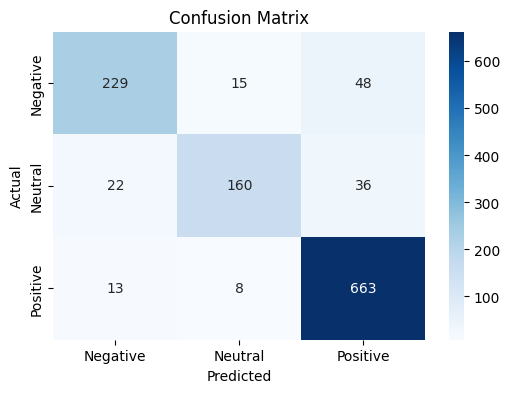

In [39]:
# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Shutdown Ray
ray.shutdown()